### New Model Solution

In [1]:
import math
import numpy
from gurobipy import *
import os

p = 0.8
c = 0
h_List = [182,660,1155,465,46,218,270,345,1292,2235,2770,1350,195,2129,8697,2775,172,27,900,17201,1279,21780]
b_List = [1000,1000,1000,1000,1000,1000,1000,1000,5000,1000,5000,1000,1000,5000,10000,5000,1000,1000,1000,20000,5000,40000]
L_List = [19,15,8,9,9,6,9,8,16,15,6,7,2,7,5,10,11,35,10,8,7,4]
F_S_S = []
solution = []

S_MAX = 51
B_MAX = 51
N = 22
Structure = [[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[0,1],[-1],[2,3,4],[-1],[-1],[5,6,7],[8,9,10],[11,12],[-1],[-1],[-1],[13,14,15],[16,17],[18,19,20]]
S_in_supplier = [10,10,10,10,10,10,10,10,1e20,10,1e20,10,10,1e20,1e20,1e20,10,10,10,1e20,1e20,1e20]
S_out_customer = [1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,5]

for i in range (N): #re-scaling
    b_List[i] = b_List[i] * 10 / 100.0
    h_List[i] = h_List[i] / 100.0

FSSFile = open("FSSFile.txt", mode='w')

def Cost (j,B,W,S_out):
    if (B == 0):
        if (W+L_List[j]-S_out > 0):
            return c+b_List[j]
        else:
            return c
    sum_1 = 0
    for x in range (0,int(W+L_List[j]-S_out-B)):
        sum_1 += math.factorial(B)/math.factorial(x)/math.factorial(B-x)*(p**x)*((1-p)**(B-x))
    sum_2 = 0
    for k in range (1,int(2*B-W-L_List[j]+S_out+1)):
        x = W+k+L_List[j]-S_out-B
        if (x < 0):
            continue
        sum_2 += k*h_List[j]*math.factorial(B)/math.factorial(x)/math.factorial(B-x)*(p**x)*((1-p)**(B-x))
    cost = c+b_List[j]*sum_1+sum_2
    return cost

for S_in in range (0,S_MAX):
    temp = []
    for S_out in range (0,S_MAX):
        BaseStock = numpy.ones(N).tolist()
        Waiting = numpy.zeros(N).tolist()
        SubCost = []
        for j in range (N):
            SubCost.append(5000)
        for j in range (N):
            for B in range (0,B_MAX):
                for W in range (max(S_in,S_out+B-L_List[j]), int(2*B+S_out-L_List[j]+1)):
                    if (SubCost[j] > Cost(j,B,W,S_out)):
                        SubCost[j] = Cost(j,B,W,S_out)
                        BaseStock[j] = B
                        Waiting[j] = W
            FSSFile.write(str(j)+'\t'+str(S_in)+'\t'+str(S_out)+'\t'+str(SubCost[j])+'\t'+str(BaseStock[j])+'\t'+str(Waiting[j])+'\n')
        temp.append([SubCost,BaseStock,Waiting])
        print(S_in,S_out,"success")
    F_S_S.append(temp)

F_S_S = numpy.array(F_S_S)
print("F_S_S generated!")
FSSFile.close()

'''
FSSFile = open("FSSFile.txt", mode='r')
FSS_temp = []
while True:
    FSSLine = FSSFile.readline()
    if FSSLine:
        FSSLine = FSSLine[:-1]
        FSS_temp.append(list(map(float,FSSLine.split('\t'))))
    else:
        break
for S_in in range (0,S_MAX):
    temp = []
    for S_out in range (0,S_MAX):
        BaseStock = numpy.ones(N).tolist()
        Waiting = numpy.zeros(N).tolist()
        SubCost = []
        for j in range (N):
            SubCost.append(1e20)
        for j in range (N):
            SubCost[j] = FSS_temp[N*S_MAX*S_in+N*S_out+j][3]
            BaseStock[j] = int(FSS_temp[N*S_MAX*S_in+N*S_out+j][4])
            Waiting[j] = int(FSS_temp[N*S_MAX*S_in+N*S_out+j][5])
        temp.append([SubCost,BaseStock,Waiting])
    F_S_S.append(temp)
F_S_S = numpy.array(F_S_S)
'''

Non_Start = [] #find the set of stages with upstream stages
for j in range (N):
    if (Structure[j][0] > -1):
        Non_Start.append(j)
    
#Solve MILP
try:
    m = Model("Algo-New")
    # Create variables
    chi = m.addVars(N, S_MAX, S_MAX, vtype=GRB.BINARY, name="chi")
    # Set objective
    obj = 0
    for j in range (N):
        for mu in range (S_MAX):
            for nu in range (S_MAX):
                obj += F_S_S[mu,nu,0,j]*chi[j,mu,nu]
    m.setObjective(obj, GRB.MINIMIZE)
    # Add constraint
    for j in range (N):
        m.addConstr(quicksum(chi[j,mu,nu] for mu in range (S_MAX) for nu in range (S_MAX)) == 1)
        if (S_out_customer[j] < 1e20):
            m.addConstr(quicksum(nu*chi[j,mu,nu] for mu in range (S_MAX) for nu in range (S_MAX)) == S_out_customer[j])
        if (S_in_supplier[j] < 1e20):
            m.addConstr(quicksum(mu*chi[j,mu,nu] for mu in range (S_MAX) for nu in range (S_MAX)) == S_in_supplier[j])
    for i in range (len(Non_Start)):
        for j in Structure[Non_Start[i]]:
            m.addConstr(quicksum(mu*chi[Non_Start[i],mu,nu] for mu in range (S_MAX) for nu in range (S_MAX)) >= quicksum(nu*chi[j,mu,nu] for mu in range (S_MAX) for nu in range (S_MAX)))
    
    m.optimize()

except GurobiError as e:
    print('Error code ' + str(e.errno) + ': ' + str(e))

except AttributeError:
    print('Encountered an attribute error')
    
for j in range (N):
    for mu in range (S_MAX):
        for nu in range (S_MAX):
            if(chi[j,mu,nu].X == 1):
                solution.append([F_S_S[mu,nu,0,j],mu,nu,F_S_S[mu,nu,1,j],F_S_S[mu,nu,2,j]]) #obj,S_in,S_out,B,W
solution = numpy.array(solution)
print("solution:",solution)
total_cost = 0
for j in range (N):
    total_cost += solution[j,0]
print("optimal total cost:", total_cost)

0 0 success
0 1 success
0 2 success
0 3 success
0 4 success
0 5 success
0 6 success
0 7 success
0 8 success
0 9 success
0 10 success
0 11 success
0 12 success
0 13 success
0 14 success
0 15 success
0 16 success
0 17 success
0 18 success
0 19 success
0 20 success
0 21 success
0 22 success
0 23 success
0 24 success
0 25 success
0 26 success
0 27 success
0 28 success
0 29 success
0 30 success
0 31 success
0 32 success
0 33 success
0 34 success
0 35 success
0 36 success
0 37 success
0 38 success
0 39 success
0 40 success
0 41 success
0 42 success
0 43 success
0 44 success
0 45 success
0 46 success
0 47 success
0 48 success
0 49 success
0 50 success
1 0 success
1 1 success
1 2 success
1 3 success
1 4 success
1 5 success
1 6 success
1 7 success
1 8 success
1 9 success
1 10 success
1 11 success
1 12 success
1 13 success
1 14 success
1 15 success
1 16 success
1 17 success
1 18 success
1 19 success
1 20 success
1 21 success
1 22 success
1 23 success
1 24 success
1 25 success
1 26 success
1 27 s

12 19 success
12 20 success
12 21 success
12 22 success
12 23 success
12 24 success
12 25 success
12 26 success
12 27 success
12 28 success
12 29 success
12 30 success
12 31 success
12 32 success
12 33 success
12 34 success
12 35 success
12 36 success
12 37 success
12 38 success
12 39 success
12 40 success
12 41 success
12 42 success
12 43 success
12 44 success
12 45 success
12 46 success
12 47 success
12 48 success
12 49 success
12 50 success
13 0 success
13 1 success
13 2 success
13 3 success
13 4 success
13 5 success
13 6 success
13 7 success
13 8 success
13 9 success
13 10 success
13 11 success
13 12 success
13 13 success
13 14 success
13 15 success
13 16 success
13 17 success
13 18 success
13 19 success
13 20 success
13 21 success
13 22 success
13 23 success
13 24 success
13 25 success
13 26 success
13 27 success
13 28 success
13 29 success
13 30 success
13 31 success
13 32 success
13 33 success
13 34 success
13 35 success
13 36 success
13 37 success
13 38 success
13 39 success
13

24 1 success
24 2 success
24 3 success
24 4 success
24 5 success
24 6 success
24 7 success
24 8 success
24 9 success
24 10 success
24 11 success
24 12 success
24 13 success
24 14 success
24 15 success
24 16 success
24 17 success
24 18 success
24 19 success
24 20 success
24 21 success
24 22 success
24 23 success
24 24 success
24 25 success
24 26 success
24 27 success
24 28 success
24 29 success
24 30 success
24 31 success
24 32 success
24 33 success
24 34 success
24 35 success
24 36 success
24 37 success
24 38 success
24 39 success
24 40 success
24 41 success
24 42 success
24 43 success
24 44 success
24 45 success
24 46 success
24 47 success
24 48 success
24 49 success
24 50 success
25 0 success
25 1 success
25 2 success
25 3 success
25 4 success
25 5 success
25 6 success
25 7 success
25 8 success
25 9 success
25 10 success
25 11 success
25 12 success
25 13 success
25 14 success
25 15 success
25 16 success
25 17 success
25 18 success
25 19 success
25 20 success
25 21 success
25 22 succe

35 34 success
35 35 success
35 36 success
35 37 success
35 38 success
35 39 success
35 40 success
35 41 success
35 42 success
35 43 success
35 44 success
35 45 success
35 46 success
35 47 success
35 48 success
35 49 success
35 50 success
36 0 success
36 1 success
36 2 success
36 3 success
36 4 success
36 5 success
36 6 success
36 7 success
36 8 success
36 9 success
36 10 success
36 11 success
36 12 success
36 13 success
36 14 success
36 15 success
36 16 success
36 17 success
36 18 success
36 19 success
36 20 success
36 21 success
36 22 success
36 23 success
36 24 success
36 25 success
36 26 success
36 27 success
36 28 success
36 29 success
36 30 success
36 31 success
36 32 success
36 33 success
36 34 success
36 35 success
36 36 success
36 37 success
36 38 success
36 39 success
36 40 success
36 41 success
36 42 success
36 43 success
36 44 success
36 45 success
36 46 success
36 47 success
36 48 success
36 49 success
36 50 success
37 0 success
37 1 success
37 2 success
37 3 success
37 4 s

47 16 success
47 17 success
47 18 success
47 19 success
47 20 success
47 21 success
47 22 success
47 23 success
47 24 success
47 25 success
47 26 success
47 27 success
47 28 success
47 29 success
47 30 success
47 31 success
47 32 success
47 33 success
47 34 success
47 35 success
47 36 success
47 37 success
47 38 success
47 39 success
47 40 success
47 41 success
47 42 success
47 43 success
47 44 success
47 45 success
47 46 success
47 47 success
47 48 success
47 49 success
47 50 success
48 0 success
48 1 success
48 2 success
48 3 success
48 4 success
48 5 success
48 6 success
48 7 success
48 8 success
48 9 success
48 10 success
48 11 success
48 12 success
48 13 success
48 14 success
48 15 success
48 16 success
48 17 success
48 18 success
48 19 success
48 20 success
48 21 success
48 22 success
48 23 success
48 24 success
48 25 success
48 26 success
48 27 success
48 28 success
48 29 success
48 30 success
48 31 success
48 32 success
48 33 success
48 34 success
48 35 success
48 36 success
48

In [2]:
p = 0.8
sigma=math.sqrt(p*(1-p)/4)
mu_model = 1-p/2
c = 0
h_List = [182,660,1155,465,46,218,270,345,1292,2235,2770,1350,195,2129,8697,2775,172,27,900,17201,1279,21780]
b_List = [1000,1000,1000,1000,1000,1000,1000,1000,5000,1000,5000,1000,1000,5000,10000,5000,1000,1000,1000,20000,5000,40000]
L_List = [19,15,8,9,9,6,9,8,16,15,6,7,2,7,5,10,11,35,10,8,7,4]

N = 22
Structure = [[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[0,1],[-1],[2,3,4],[-1],[-1],[5,6,7],[8,9,10],[11,12],[-1],[-1],[-1],[13,14,15],[16,17],[18,19,20]]
S_in_supplier = [10,10,10,10,10,10,10,10,1e20,10,1e20,10,10,1e20,1e20,1e20,10,10,10,1e20,1e20,1e20]
S_out_customer = [1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,5]

for i in range (N): #re-scaling
    b_List[i] = b_List[i] * 10 / 100.0
    h_List[i] = h_List[i] / 100.0

New_Binomial = open("New-Binomial-Simulation.txt", mode='w')
New_Poisson = open("New-Poisson-Simulation.txt", mode='w')

S_in_List = solution[:,1].tolist()
S_out_List = solution[:,2].tolist()
B_List = solution[:,3].tolist()
W_List = solution[:,4].tolist()

Non_Start = [] #find the set of stages with upstream stages
for j in range (N):
    if (Structure[j][0] > -1):
        Non_Start.append(j)
for i in range (len(Non_Start)):
    max_S = 0
    for j in Structure[Non_Start[i]]:
        if (max_S < S_out_List[j]):
            max_S = S_out_List[j]
    S_in_List[Non_Start[i]] = max_S

print("S_in:",S_in_List)
print("S_out:",S_out_List)
print("B:",B_List)
print("W:",W_List)

#simulation-binomial
for w in range (100):
    numpy.random.seed(w+10)
    Z = numpy.random.binomial(1,p,500).tolist() #Z-1
    demand = [] #real-time demand 0 or 1
    for z in Z:
        if (z == 0):
            demand.append(1)
        else:
            demand.append(0)
            demand.append(1)
    cost = numpy.zeros(N).tolist()
    backordertimes = numpy.zeros(N).tolist()
    for i in range (N):
        stock = []
        stock.append(B_List[i])
        for j in range (1, len(demand)):
            stock.append(stock[j-1])
            if ((j-S_out_List[i]) >= 0):
                stock[j] -= demand[int(j-S_out_List[i])]
            if ((j-W_List[i]-L_List[i]) >= 0):
                stock[j] += demand[int(j-W_List[i]-L_List[i])]
            if (stock[j] < 0):
                cost[i] -= stock[j]*b_List[i]
                backordertimes[i] -= stock[j]
                stock[j] = 0
            else:
                cost[i] += h_List[i]*stock[j]
    New_Binomial.write(str(w)+'\t')
    for i in range (N):
        New_Binomial.write(str(cost[i])+'\t')
    for i in range (N):
        New_Binomial.write(str(backordertimes[i])+'\t')
    New_Binomial.write('\n')
print("Simulation-Binomial Ended!")

#simulation-poisson
for w in range (100):
    numpy.random.seed(w+10)
    demand = numpy.random.poisson(mu_model,int((1-p+2*p)*500)).tolist()
    cost = numpy.zeros(N).tolist()
    backordertimes = numpy.zeros(N).tolist()
    for i in range (N):
        stock = []
        stock.append(B_List[i])
        for j in range (1, len(demand)):
            stock.append(stock[j-1])
            if ((j-S_out_List[i]) >= 0):
                stock[j] -= demand[int(j-S_out_List[i])]
            if ((j-W_List[i]-L_List[i]) >= 0):
                stock[j] += demand[int(j-W_List[i]-L_List[i])]
            if (stock[j] < 0):
                cost[i] -= stock[j]*b_List[i]
                backordertimes[i] -= stock[j]
                stock[j] = 0
            else:
                cost[i] += h_List[i]*stock[j]
    New_Poisson.write(str(w)+'\t')
    for i in range (N):
        New_Poisson.write(str(cost[i])+'\t')
    for i in range (N):
        New_Poisson.write(str(backordertimes[i])+'\t')
    New_Poisson.write('\n')
print("Simulation-Poisson Ended!")
New_Binomial.close() #every row: k,w,cost of stages 0~21, backorder times of stages 0~21
New_Poisson.close()

S_in: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0, 19.0, 10.0, 10.0, 19.0, 25.0, 17.0, 10.0, 10.0, 10.0, 30.0, 1.0, 1.0]
S_out: [9.0, 9.0, 18.0, 19.0, 19.0, 16.0, 19.0, 18.0, 25.0, 25.0, 25.0, 17.0, 12.0, 26.0, 30.0, 27.0, 1.0, 1.0, 0.0, 1.0, 1.0, 5.0]
B: [13.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0, 28.0, 12.0, 22.0, 5.0, 0.0]
W: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 9.0, 10.0, 19.0, 10.0, 10.0, 19.0, 25.0, 17.0, 10.0, 10.0, 10.0, 30.0, 1.0, 1.0]
Simulation-Binomial Ended!
Simulation-Poisson Ended!


# Below are tests

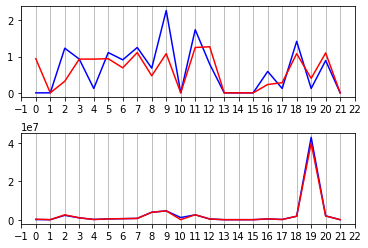

In [14]:
import os
import numpy
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import brewer2mpl
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

Backorder = []
Cost = []

File = open("New-Binomial-Simulation.txt", mode='r')
while True:
    Line = File.readline()
    if Line:
        Line = Line[:-2]
        Line = list(map(float,Line.split('\t')))
        Line = Line[1:]
        Backorder.append((Line[22:44]))
        Cost.append((Line[0:22]))
    else:
        break
File.close()

Ba_New = numpy.average(Backorder, axis=0)
Cost_New = numpy.average(Cost, axis=0)

Backorder = []
Cost = []

File = open("Trad-Binomial-Simulation.txt", mode='r')
while True:
    Line = File.readline()
    if Line:
        Line = Line[:-2]
        Line = list(map(float,Line.split('\t')))
        Line = Line[2:]
        Backorder.append((Line[22:44]))
        Cost.append((Line[0:22]))
        if len(Backorder) == 100:
            break
    else:
        break
File.close()

Ba_Trad = numpy.average(Backorder, axis=0)
Cost_Trad = numpy.average(Cost, axis=0)

fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(Ba_New, color='b')
ax.plot(Ba_Trad, color='r')
ax.grid(axis="x")
x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
ax=fig.add_subplot(212)
ax.plot(Cost_New, color='b')
ax.plot(Cost_Trad, color='r')
ax.grid(axis="x")
x_major_locator=MultipleLocator(1)
ax.xaxis.set_major_locator(x_major_locator)
plt.subplots_adjust(hspace =0.4)
plt.show()

In [38]:
import math
import numpy
from gurobipy import *
import os

p = 0.8
c = 0
h_List = [182,660,1155,465,46,218,270,345,1292,2235,2770,1350,195,2129,8697,2775,172,27,900,17201,1279,21780]
b_List = [10000,10000,10000,10000,10000,10000,10000,10000,1e5,1e4,1e5,10000,10000,1e5,1e6,1e5,10000,10000,1e4,1e7,1e5,1e8]
L_List = [19,15,8,9,9,6,9,8,16,15,6,7,2,7,5,10,11,35,10,8,7,4]

S_MAX = 41
B_MAX = 41
N = 22
Structure = [[-1],[-1],[-1],[-1],[-1],[-1],[-1],[-1],[0,1],[-1],[2,3,4],[-1],[-1],[5,6,7],[8,9,10],[11,12],[-1],[-1],[-1],[13,14,15],[16,17],[18,19,20]]
S_in_supplier = [10,10,10,10,10,10,10,10,1e20,10,1e20,10,10,1e20,1e20,1e20,10,10,10,1e20,1e20,1e20]
S_out_customer = [1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,1e20,5]

FSSFile = open("FSSFile.txt", mode='w')

def Cost (j,B,W,S_out):
    if (B == 0):
        if (W+L_List[j]-S_out > 0):
            return c+b_List[j]
        else:
            return c
    sum_1 = 0
    for x in range (0,int(W+L_List[j]-S_out-B)):
        sum_1 += math.factorial(B)/math.factorial(x)/math.factorial(B-x)*(p**x)*((1-p)**(B-x))
    sum_2 = 0
    for k in range (1,int(2*B-W-L_List[j]+S_out+1)):
        x = W+k+L_List[j]-S_out-B
        if (x < 0):
            continue
        sum_2 += k*h_List[j]*math.factorial(B)/math.factorial(x)/math.factorial(B-x)*(p**x)*((1-p)**(B-x))
    cost = c+b_List[j]*sum_1+sum_2
    print(sum_1,sum_2)
    return cost

print(Cost(9,12,10,4))
print(Cost(9,12,11,5))

S_in_List = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 28.0, 10.0, 0, 10.0, 10.0, 2.0, 5.0, 0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0]
S_out_List = [28.0, 25.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 5.0, 5.0, 5.0, 0.0, 0.0, 9.0, 10.0, 10.0, 1.0, 1.0, 0.0, 1.0, 1.0, 5.0]
B_List = [1.0, 0.0, 11.0, 12.0, 13.0, 9.0, 11.0, 10.0, 24.0, 12.0, 1.0, 10.0, 8.0, 0.0, 0.0, 0.0, 13.0, 28.0, 12.0, 12.0, 5.0, 0.0]
W_List = [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 28.0, 11.0, 0.0, 10.0, 10.0, 2.0, 5.0, 0.0, 10.0, 10.0, 10.0, 10.0, 1.0, 1.0]
total_cost = 0
total_backorder = 0
for w in range (100):
    numpy.random.seed(w+10)
    Z = numpy.random.binomial(1,p,500).tolist() #Z-1
    demand = [] #real-time demand 0 or 1
    for z in Z:
        if (z == 0):
            demand.append(1)
        else:
            demand.append(0)
            demand.append(1)
    cost = numpy.zeros(N).tolist()
    backordertimes = numpy.zeros(N).tolist()
    for i in [9]:
        stock = []
        stock.append(B_List[i])
        for j in range (1, len(demand)):
            stock.append(stock[j-1])
            if ((j-S_out_List[i]) >= 0):
                stock[j] -= demand[int(j-S_out_List[i])]
            if ((j-W_List[i]-L_List[i]) >= 0):
                stock[j] += demand[int(j-W_List[i]-L_List[i])]
            if (stock[j] < 0):
                cost[i] -= stock[j]*b_List[i]
                backordertimes[i] -= stock[j]
                stock[j] = 0
            else:
                cost[i] += h_List[i]*stock[j]
        total_cost += cost[i]
        total_backorder += backordertimes[i]
print(total_cost/100,total_backorder/100)

0.2054310502399999 2015.8429003776005
4070.1534027775997
0.2054310502399999 2015.8429003776005
4070.1534027775997
4615245.05 2.27


In [1]:
4593900.8 2.27

SyntaxError: invalid syntax (<ipython-input-1-959ca802b6ea>, line 1)

In [4]:
import numpy

numpy.random.poisson(1,10)

array([0, 0, 2, 0, 0, 0, 2, 2, 3, 0])